In [1]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import glob
import os
import math

os.chdir('/home/jyang4/repos/DKBO-MLDE/')
#import objectives
#import utils
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# %matplotlib notebook
import seaborn as sns

font = {'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

/home/jyang4/miniconda3/envs/dkbo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Analyze the distribution of sequences
5site libraries

/tmp/ipykernel_267850/1468672752.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_267850/1468672752.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_267850/1468672752.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

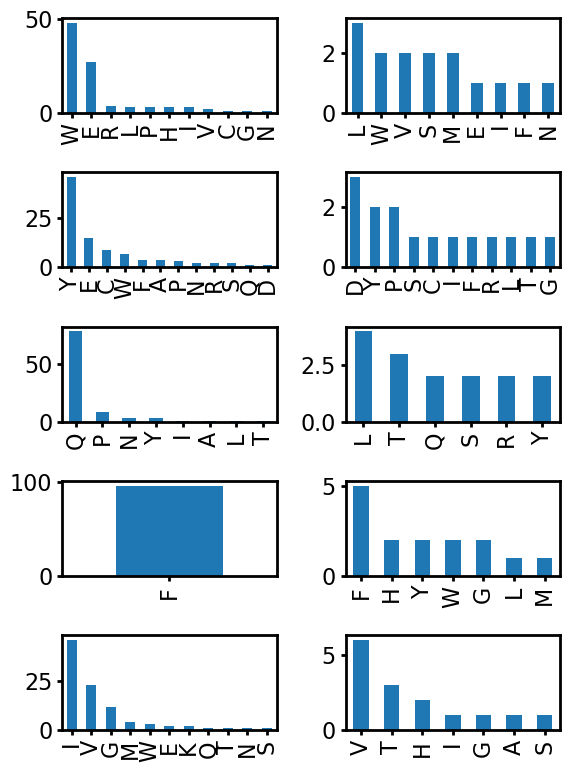

In [18]:
#just to get a mapping from indices to combos
fitness_df = pd.DataFrame()
combos = np.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/combos.npy')
fitness_df['Combo'] = combos
fitness_df

plt.figure(figsize=(6, 8))
for i in [1]:
    for j in  [0, 1]:
        if j == 0:
            # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_1indices.pt')
            indices= torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/DKL_BOTORCH-DO-0-RBF-TS-[10, 10]_1indices.pt')
            # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/GP_BOTORCH-DO-0-RBF-UCB-[100, 1]_1indices.pt')

            
            subset = fitness_df.iloc[indices, :].reset_index()
            batch = subset[-96:]
        
        #second column is the distribution of live variants
        if j == 1:
            data = pd.read_csv('/home/jyang4/repos/data/Pgb/test_fivesite.csv')
            batch = data[:15]

        n = 1
        for l in range(5):
            batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])

        for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4', 'AA5']):
            plt.subplot(5, 2, j + 2*k + 1)
            batch[label].value_counts().plot(kind="bar")
            #sns.countplot(x=label, data=batch)
    plt.tight_layout()

In [22]:
subset[-96:]

,index,Combo
261,2909318,WEQFI
262,3037314,WYQFI
263,637517,EYQFI
264,637527,EYQFV
265,3029314,WWQFI
...,...,...
352,637127,EYPFV
353,2733340,VCQFI
354,3005316,WSQFI
355,573519,ENQFI


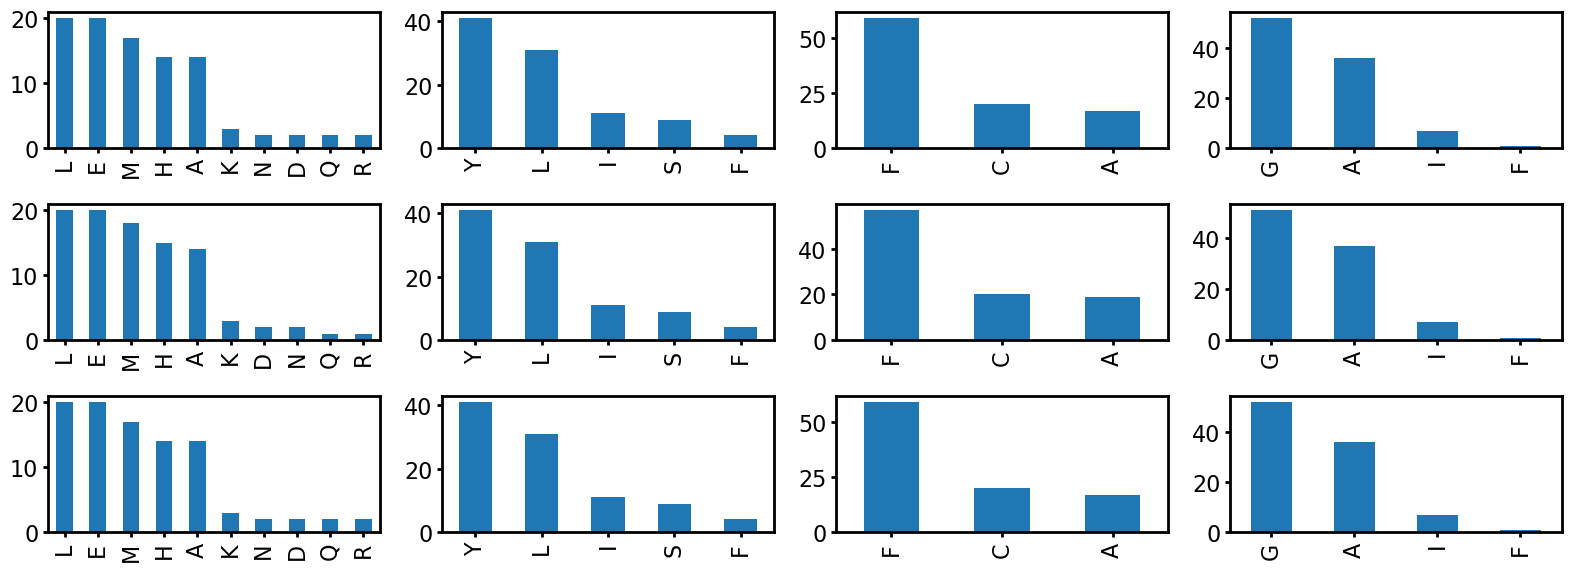

In [48]:
subdir = '/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot'
tensors = sorted(glob.glob(subdir + '/*indices*.pt'))

fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')

plt.figure(figsize=(16, 6))
for i in [2]:
    for j, acq in enumerate(['UCB', 'TS', 'GREEDY']):

        indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-%s-[10, 10]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-%s-[80, 1]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/TrpB_onehot/CDKL-DO-0-RBF-%s-[32, 32]_%dindices.pt' % (acq, i+1))

        subset = fitness_df.iloc[indices, :].reset_index()

        n = 1 #first batch after the random initialization
        batch = subset[96*n:96*(n+1)]
        for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4']):
            plt.subplot(3, 4, 4*j + k+1)
            batch[label].value_counts().plot(kind="bar")
            #sns.countplot(x=label, data=batch)
    plt.tight_layout()

TS proposes more diverse samples compared to UCB, especially for the GP. For DKL, the model is less pronounced

In [35]:
data = torch.load('/home/jyang4/repos/DKBO-MLDE/results/archived/trpB_onehot/DKL-DO-0-RBF-TS-[10, 10]_6indices.pt')
data.shape

torch.Size([480])

(array([ 77., 109., 158., 226., 171., 155.,  65.,  27.,   8.,   4.]),
 array([0.04903082, 0.14412774, 0.23922465, 0.33432157, 0.42941849,
        0.52451541, 0.61961233, 0.71470925, 0.80980616, 0.90490308,
        1.        ]),
 <BarContainer object of 10 artists>)

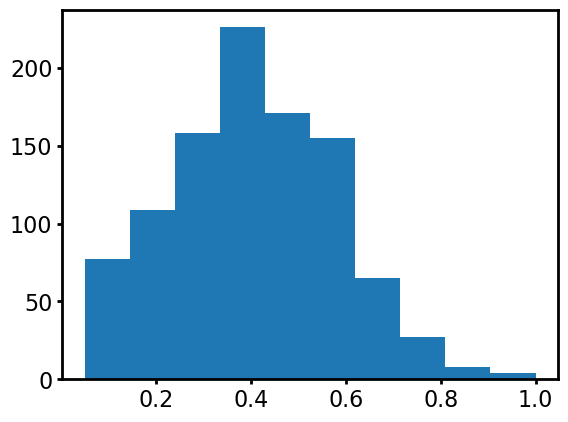

In [142]:
data = pd.read_csv('/home/jyang4/repos/data/TrpB_fitness.csv')
#randomly select 96 rows
maxes = []
for i in range(1000):
    indices = np.random.choice(data.shape[0], 96, replace=False)
    maxes.append(data['fitness'][indices].max())
plt.hist(maxes)

### Analyze the mean and uncertainty values

Maybe should only look at a subset of the values?

Text(0.5, 1.0, '$\\mu$')

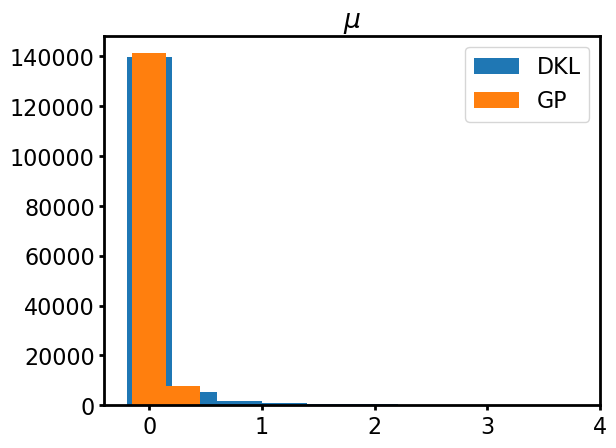

In [2]:
sigma_DKL = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/sigma_DKL.pt')
mu_DKL = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/mu_DKL.pt')
sigma_GP = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/sigma_GP.pt')
mu_GP = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/mu_GP.pt')

plt.hist(mu_DKL)
plt.hist(mu_GP)
plt.legend(['DKL', 'GP'])
plt.title('$\mu$')

Text(0.5, 1.0, '$\\sigma$')

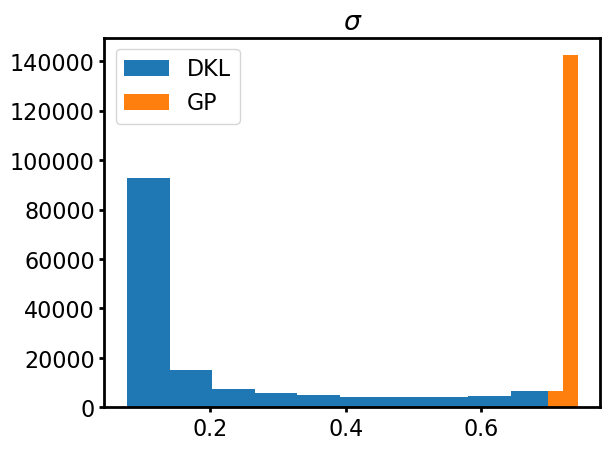

In [3]:
plt.hist(sigma_DKL)
plt.hist(sigma_GP)
plt.legend(['DKL', 'GP'])
plt.title('$\sigma$')

### see if uncertainty is calibrated with fitness

Is it correlated to error in the model?

In [27]:
mu = mu_GP
sigma = sigma_GP

normalized = sigma/mu
normalized

tensor([  9.7333, -22.8082, -20.9579,  ...,   2.7345,  10.2063,   9.1704],
       dtype=torch.float64)

Text(0, 0.5, '$\\mu$')

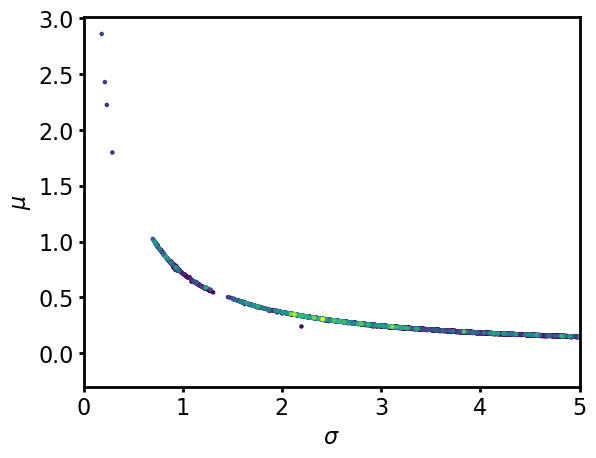

In [28]:
from scipy.stats import pearsonr

fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')

fitness_df['fit'] = fitness_df['fit']/fitness_df['fit'].max()

fitness_df['sigma'] = sigma
fitness_df['mu'] = mu
fitness_df['normalized_sigma'] = normalized

fitness_df.sort_values('fit', ascending=True, inplace=True)

#sns.jointplot(fitness_df, x='sigma',  y='mu')
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['mu'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

Text(0, 0.5, 'UCB')

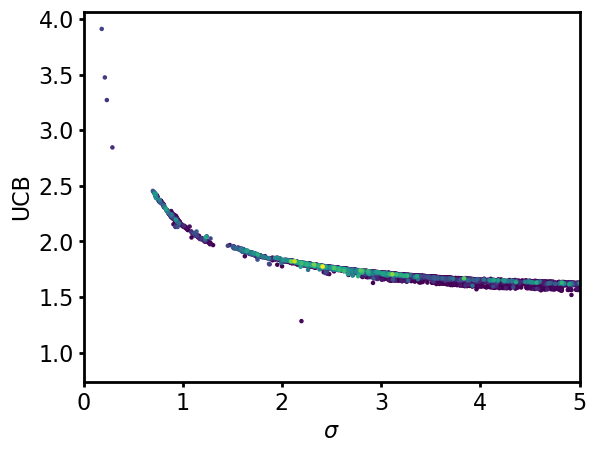

In [29]:
fitness_df['delta'] = fitness_df['mu'] + 2 * fitness_df['sigma']
#fitness_df = fitness_df.sort_values('delta', ascending=False)[:96]

#sns.jointplot(fitness_df, x = 'sigma', y = 'delta', s =2)
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['delta'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('UCB')

Text(0, 0.5, 'UCB')

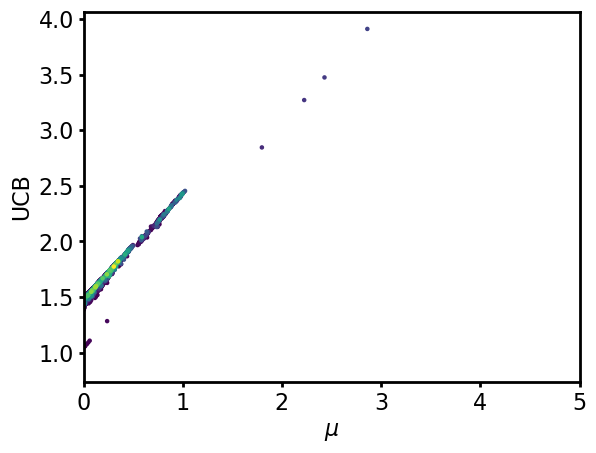

In [30]:
#sns.jointplot(fitness_df, x = 'sigma', y = 'delta', s =2)
plt.scatter(x = fitness_df['mu'], y =fitness_df['delta'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\mu$')
plt.ylabel('UCB')

PearsonRResult(statistic=-1.530120687791388e-05, pvalue=0.9952817799795382)


Text(0, 0.5, 'error')

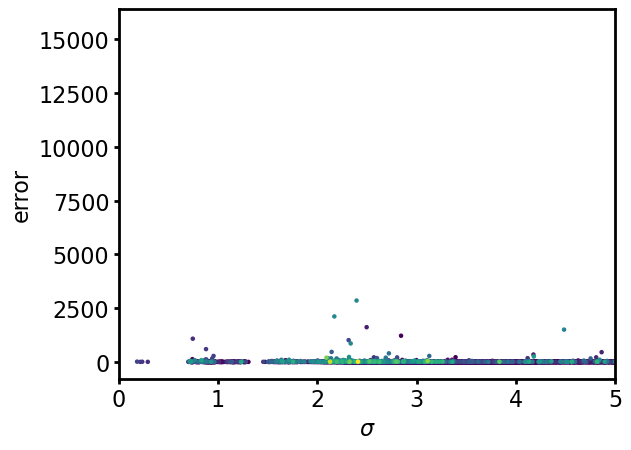

In [31]:
fitness_df['error'] = abs((mu - fitness_df['fit'])/mu)

#fitness_df['error'] = abs((fitness_df['mu'] - fitness_df['fit']))
print(pearsonr(fitness_df['normalized_sigma'], fitness_df['error']))

#sns.jointplot(fitness_df, x = 'sigma', y = 'error', s =2)
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['error'], c=fitness_df['fit'], cmap='viridis', s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('error')

### Analyze whether there is mode collapse

In [92]:
embeddings = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/embeddings_2.pt') # onehot, DKL, TS
#embeddings = torch.load('/home/jyang4/repos/data/trpB_onehot_x.pt')
fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')
embeddings = embeddings.detach().numpy()
embeddings.shape

(149361, 10)

In [93]:
for row in embeddings:
    if len(np.where((embeddings == row).all(axis=1))[0]) > 1:
        print('bad')

KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

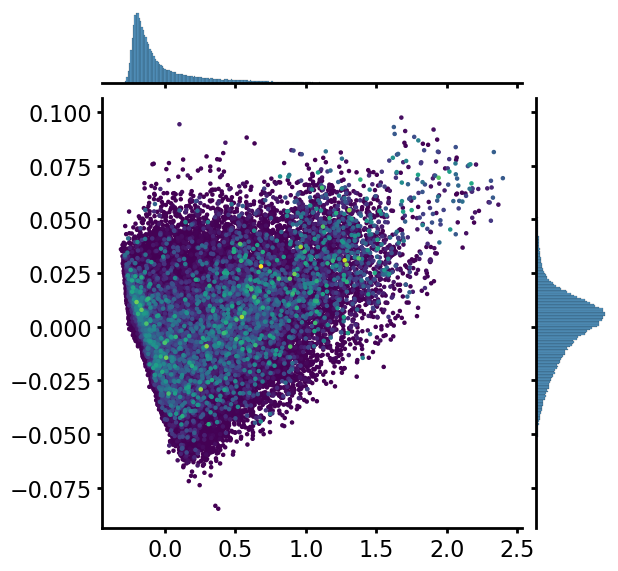

In [95]:
#PCA transform on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

#plot the embeddings
plt.figure(figsize=(12, 8))
fitness = fitness_df['fit'].values
#reorder the embeddings so they are based on fitness
indices = np.argsort(fitness)
sorted_fitness = fitness[indices]

sns.jointplot(x=pca_embeddings[indices, 0], y=pca_embeddings[indices, 1],s = 2)
plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=sorted_fitness, cmap='viridis', s=5)